In [1]:
import sys, importlib
# "../" to go back one director
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
import os
# import torch.nn as nn
# from Modules.Utils.Imports import *
# from Modules.Utils.JTNPDESolver import *
# from Modules.Utils.Gradient import Gradient
# from Modules.Utils.ModelWrapper import ModelWrapper
# from Modules.Models.BuildSurfaceFitter import *
# from torch.autograd import Variable
# import Modules.Utils.PDESolver as PDESolver
# import DataFormatter as DF

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import scipy.io
from scipy import integrate, interpolate
from scipy.sparse import spdiags
from scipy import sparse
import bisect
import matplotlib.colors as colors
import matplotlib.cm as cm
from Projects.Scripts.Plotters import *

In [2]:
path = os.getcwd()+'/NPY_Data/data_wider_2P_E2.npy'
data = np.load(path, allow_pickle=True).item()

x = data['x']
t = data['t']
t = t[:26]
U = data['u_noise']
U = U[:,:26]
# t = t/
X, T = np.meshgrid(x, t, indexing='ij')

shape = U.shape

# flatten for MLP
inputs = np.concatenate([X.reshape(-1)[:, None],
                         T.reshape(-1)[:, None]], axis=1)
outputs = U.reshape(-1)[:, None]

In [3]:
# Get data
u_data = outputs.reshape(shape)
x = data['x']
t = data['t']

In [5]:
max_D_nodes = 20
max_rho_nodes = 20
max_K_nodes = 1

D_min = 0.0
D_max = 0.12
rho_min = 0.0
rho_max = 12.0
K_min = 1.0
K_max = 1.0

weights_mesh = data['pdf_mesh']

numX = len(x)
numT = len(t)
numData = numX*numT
numData = np.float(numData)

num_D_nodes = [5, 10, 20]
num_rho_nodes = [5, 10, 20]


#### Interpolation
load_file = 'PMF_Results_Interp_2P_E2/best_PMF.npy'     
best_results_Interp = np.load(load_file, allow_pickle=True).item()
        
# Interp_best_numDnode = best_numDnode
# Interp_best_numKnode = best_numKnode
# Interp_weights = best_weights
Interp_RSS = best_results_Interp['best_RSS']

D_vec = np.linspace(D_min, D_max, max_D_nodes)
rho_vec = np.linspace(rho_min, rho_max, max_rho_nodes)
K_vec = np.linspace(K_min, K_max, max_K_nodes)

num_D_node = best_results_Interp['best_numDnode']
num_rho_node = best_results_Interp['best_numRhonode']
weights = best_results_Interp['best_weights']
weights = weights.reshape((best_results_Interp['best_numDnode'],best_results_Interp['best_numRhonode']))

D_vec_idx = np.floor(np.linspace(0,max_D_nodes-1, num_D_node))
rho_vec_idx = np.floor(np.linspace(0,max_rho_nodes-1, num_rho_node))
D_vec_idx = D_vec_idx.astype(int)
rho_vec_idx = rho_vec_idx.astype(int)

D_vec = D_vec[D_vec_idx]
rho_vec = rho_vec[rho_vec_idx]

/var/folders/tf/124zrkp12d32s2b41mk0ps6h0000gn/T/ipykernel_20370/32976038.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numData = np.float(numData)


In [6]:
D_mesh, rho_mesh = np.meshgrid(D_vec, rho_vec, indexing='ij')

D_idx = np.arange(num_D_node)
rho_idx = np.arange(num_rho_node)
D_idx_mesh, rho_idx_mesh = np.meshgrid(D_idx, rho_idx, indexing='ij')

In [7]:
D_mesh = D_mesh.reshape((1,-1))
rho_mesh = rho_mesh.reshape((1,-1))

D_idx_mesh = D_idx_mesh.reshape((1,-1))
rho_idx_mesh = rho_idx_mesh.reshape((1,-1))

weights = weights.reshape((1,-1))
weights_cdf = np.cumsum(weights)

# Sample 10,000 individuals from the estimated distribution
out_idx = np.zeros((10000,1))
for i in np.arange(10000):
    rand_num = np.random.uniform(low=0, high=1, size=1)
    less_rand = weights_cdf < rand_num[0]*weights_cdf[-1]
    out_idx[i] = sum(less_rand)
    
out_idx = out_idx.astype(np.int64)

In [8]:
D_coor = D_mesh[:,out_idx]
rho_coor = rho_mesh[:,out_idx]

In [9]:
count_map = np.zeros((num_D_node,num_rho_node))
for i in np.arange(10000):
    count_map[D_idx_mesh[:,out_idx[i]][0], rho_idx_mesh[:,out_idx[i]][0]] += 1

/var/folders/tf/124zrkp12d32s2b41mk0ps6h0000gn/T/ipykernel_20370/4003352783.py:3: UserWarning: The following kwargs were not used by contour: 'interpolation'
  ax.contourf(count_map.T, interpolation='nearest')


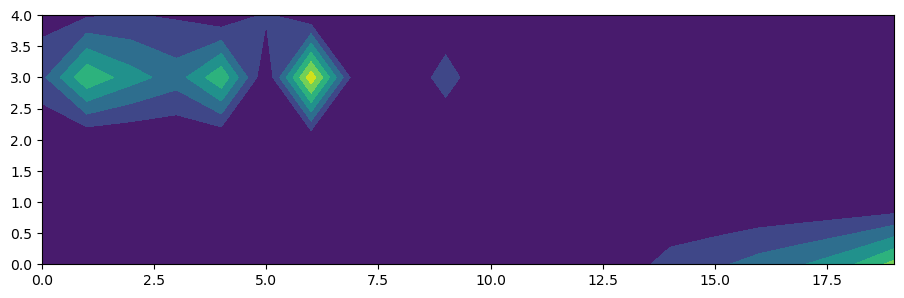

In [11]:
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(3, 1, 1)
ax.contourf(count_map.T, interpolation='nearest')

# k-mean clustering

In [12]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

coor = np.concatenate((D_coor, rho_coor), axis=0).T
coor = coor[0,:,:]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(coor)

max_n_clusters = 10

SSE = []
cluster_centers = {}

for i in np.arange(1,max_n_clusters+1):
    kmeans = KMeans(init="random",n_clusters=i,n_init=10,max_iter=300,random_state=42)
    kmeans.fit(scaled_features)
    cluster_centers[i] = kmeans.cluster_centers_
    SSE.append(kmeans.inertia_)
    
# Find the elbow
kl = KneeLocator(np.arange(1,max_n_clusters+1), SSE, curve="convex", direction="decreasing")
kl.elbow

2

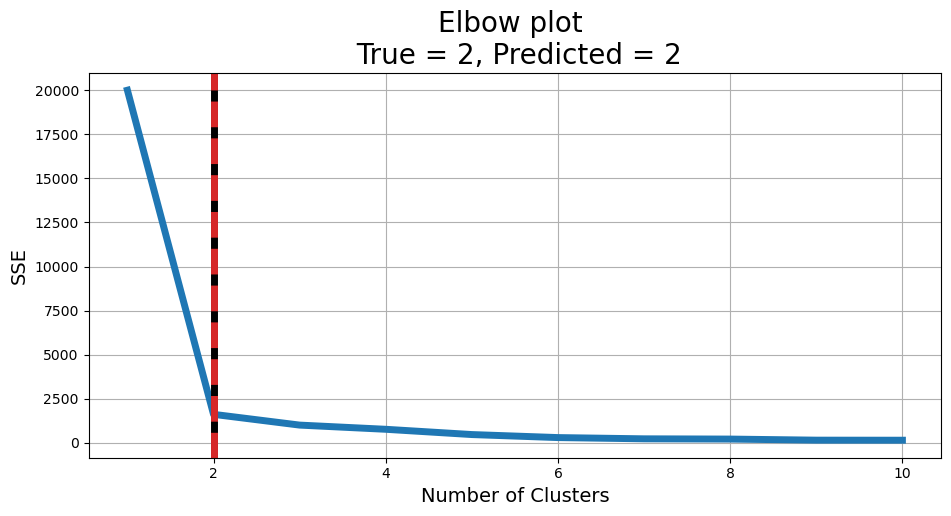

In [13]:
# Make elbow plot
true_elbow = 2

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['x', 'o', 's', 'd', '^']
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(2, 1, 1)

plt.plot(np.arange(max_n_clusters)[None,:][0]+1, SSE, '-', c=colors[0], linewidth=5)
plt.axvline(x = true_elbow, color = 'k', linewidth=5)
plt.axvline(x = kl.elbow, color = 'tab:red', linestyle='dashed', linewidth=5)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('SSE', fontsize=14)
plt.grid()
plt.title('Elbow plot \n True = %.0f, ' %true_elbow + 'Predicted = %.0f' %kl.elbow, fontsize=20)
plt.savefig('Figures/Elbow_2P_E2.pdf',bbox_inches='tight')

In [14]:
reverse_cluster_true = scaler.inverse_transform(cluster_centers[true_elbow])
reverse_cluster_pred = scaler.inverse_transform(cluster_centers[kl.elbow])

/Users/kyle/Library/CloudStorage/GoogleDrive-kcnguye2@ncsu.edu/My Drive/Projects/PMF_Project/Projects/RDE_Fisher_Dp/../../Projects/Scripts/Plotters.py:312: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7fce41c8a970> has a label of '_' which cannot be automatically added to the legend.
  PDF_ax.legend(figure_mods['legend_list'],loc='upper right')
/Users/kyle/Library/CloudStorage/GoogleDrive-kcnguye2@ncsu.edu/My Drive/Projects/PMF_Project/Projects/RDE_Fisher_Dp/../../Projects/Scripts/Plotters.py:312: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7fce41c8a9d0> has a label of '_' which cannot be automatically added to the legend.
  PDF_ax.legend(figure_mods['legend_list'],loc='upper right')
/Users/kyle/Library/CloudStorage/GoogleDrive-kcnguye2@ncsu.edu/My Drive/Projects/PMF_Project/Projects/RDE_Fisher_Dp/../../Projects/Scripts/Plotters.py:312: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7fce41c8ac70> h

(<Figure size 1100x1100 with 1 Axes>,
 <AxesSubplot:title={'center':'Predicted cluster centers'}, xlabel='Diffusion', ylabel='Growth rate'>)

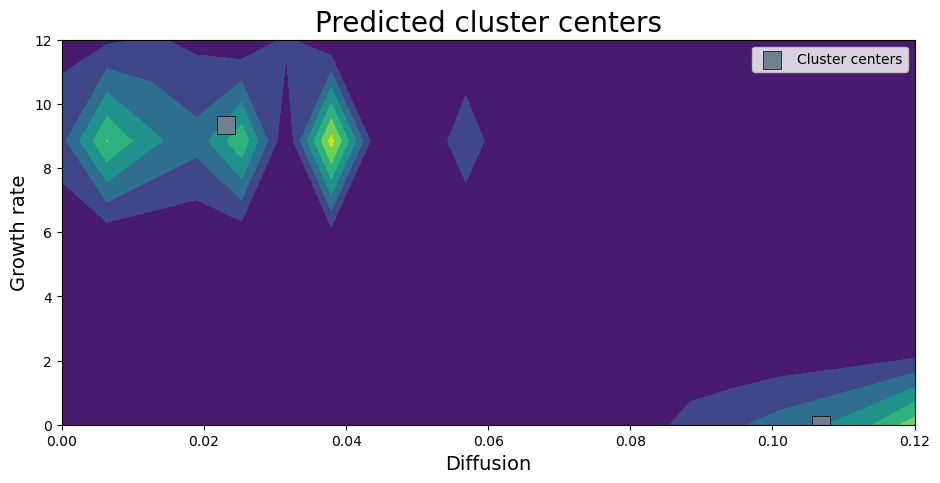

In [18]:
# plot the cluster centers on the estimated distribution
fig1, ax1 = Plot_PDF(D_mesh,
                     rho_mesh,
                     weights,
                     x_label='Diffusion', 
                     y_label='Growth rate',
                     title='Predicted cluster centers',
                     save_path=None)

figure_mods = {}
figure_mods['color'] = "slategrey"
figure_mods['linewidths'] = 0.5
figure_mods['marker'] = 's'
figure_mods['edgecolor'] = 'k'
figure_mods['size'] = 150
figure_mods['legend_list'] = ['_','_','_','_','_','_','_','Cluster centers']

Plot_CentersOnPDF(PDF_fig=fig1,
                  PDF_ax=ax1,
                  param1_center=reverse_cluster_pred[:,0],
                  param2_center=reverse_cluster_pred[:,1],
                  param1_vec=D_vec,
                  param2_vec=rho_vec,
                  figure_mods=figure_mods,
                  save_path='Figures/ClusterCenters_PredMesh_2P_E2.pdf')
# plt.show()